# Global Solution (GS) 2 - 2024 - 2 Semestre

## FIAP - Eng de Software

### Data Science & Statistical Computing

####  Pegada de Carbono - Análise de dados com AI e ML Scikit-learn



Nome: Julia Palomari RM: 551910

Nome: Leticia Fontana RM: 550289

###Chamando datasets e importando bibliotecas necessárias

FAZER UPLOAD DO KAGGLE.JSON ANTES DE RODAR O CÓDIGO

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [1]:
!kaggle datasets download -d mpwolke/cusersmarildownloadsprojectcsv
!kaggle datasets download -d anshtanwar/global-data-on-sustainable-energy
!kaggle datasets download -d valchovalev/annualdeforestation-2021

Dataset URL: https://www.kaggle.com/datasets/mpwolke/cusersmarildownloadsprojectcsv
License(s): other
100% 397k/397k [00:00<00:00, 804kB/s]
100% 397k/397k [00:00<00:00, 804kB/s]
Dataset URL: https://www.kaggle.com/datasets/anshtanwar/global-data-on-sustainable-energy
License(s): Attribution 4.0 International (CC BY 4.0)
100% 174k/174k [00:00<00:00, 531kB/s]
100% 174k/174k [00:00<00:00, 531kB/s]
Dataset URL: https://www.kaggle.com/datasets/valchovalev/annualdeforestation-2021
License(s): unknown
  0% 0.00/3.40k [00:00<?, ?B/s]
100% 3.40k/3.40k [00:00<00:00, 6.89MB/s]


In [2]:
!unzip cusersmarildownloadsprojectcsv>.zip
!unzip global-data-on-sustainable-energy>.zip
!unzip annualdeforestation-2021>.zip

In [2]:
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import aiohttp
import asyncio
import datetime
import nest_asyncio
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
import pandas as pd

df_globalsustainable = pd.read_csv('global-data-on-sustainable-energy (1).csv')
df_project2050 = pd.read_csv('project.csv', delimiter=';')
df_deforestation = pd.read_csv('annual-deforestation.csv')

###Web API

API web para buscar nomes completos de países a partir de seus códigos


In [4]:

cache = {}

async def get_country_name_async(session, country_code):
    if country_code in cache:
        return cache[country_code]

    url = f"https://restcountries.com/v3.1/alpha/{country_code}"
    async with session.get(url) as response:
        if response.status == 200:
            country_data = await response.json()
            country_name = country_data[0]['name']['common']
            cache[country_code] = country_name
            return country_name
        else:
            return None

async def fetch_country_names(country_codes):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for code in country_codes:
            tasks.append(get_country_name_async(session, code))
        return await asyncio.gather(*tasks)

def add_country_names_to_dataframe(df_project2050):
    country_codes = df_project2050['country'].unique()

    nest_asyncio.apply()

    loop = asyncio.get_event_loop()
    country_names = loop.run_until_complete(fetch_country_names(country_codes))

    country_name_map = dict(zip(country_codes, country_names))

    df_project2050['country_full'] = df_project2050['country'].map(country_name_map)
    return df_project2050

df_project20250 = add_country_names_to_dataframe(df_project2050)


###Limpando dados & Combinando bases

In [5]:
df_project2050 = df_project2050.drop(columns=['country'])
df_project2050 = df_project2050.rename(columns={'country_full': 'country'})

In [6]:
df_globalsustainable = df_globalsustainable.rename(columns={'Entity': 'country'})
df_deforestation = df_deforestation.rename(columns={'Entity': 'country'})

In [7]:
df = pd.merge(df_globalsustainable, df_deforestation, on=['country', 'Year'], how='inner')


In [8]:
print(df.isnull().sum())
print(df_project2050.isnull().sum())

df = df.dropna(subset=["Value_co2_emissions_kt_by_country",
                       "Primary energy consumption per capita (kWh/person)"])

numeric_df = df.select_dtypes(include='number')
df[numeric_df.columns] = numeric_df.fillna(numeric_df.median())
df_project2050 = df_project2050.fillna("Unknown")

df['High_CO2_Emissions'] = (df['Value_co2_emissions_kt_by_country'] > df['Value_co2_emissions_kt_by_country'].median()).astype(int)

country                                                               0
Year                                                                  0
Access to electricity (% of population)                               1
Access to clean fuels for cooking                                     9
Renewable-electricity-generating-capacity-per-capita                 85
Financial flows to developing countries (US $)                      153
Renewable energy share in the total final energy consumption (%)      0
Electricity from fossil fuels (TWh)                                   0
Electricity from nuclear (TWh)                                        5
Electricity from renewables (TWh)                                     0
Low-carbon electricity (% electricity)                                0
Primary energy consumption per capita (kWh/person)                    0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)           0
Value_co2_emissions_kt_by_country                               

In [ ]:
df_project2050.columns

Index(['sector', 'indicator', 'year', 'variable', 'value', 'unit', 'country'], dtype='object')

In [ ]:
df.columns

Index(['country', 'Year', 'Access to electricity (% of population)',
       'Access to clean fuels for cooking',
       'Renewable-electricity-generating-capacity-per-capita',
       'Financial flows to developing countries (US $)',
       'Renewable energy share in the total final energy consumption (%)',
       'Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)',
       'Electricity from renewables (TWh)',
       'Low-carbon electricity (% electricity)',
       'Primary energy consumption per capita (kWh/person)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'Value_co2_emissions_kt_by_country',
       'Renewables (% equivalent primary energy)', 'gdp_growth',
       'gdp_per_capita', 'Density\n(P/Km2)', 'Land Area(Km2)', 'Latitude',
       'Longitude', 'Code', 'Deforestation', 'High_CO2_Emissions'],
      dtype='object')

##10 Perguntas

###Questão 1: Qual é a correlação entre o desmatamento e as emissões de CO2 nos países ao longo do tempo?

Estatística descritiva e visualizações interativas para analisar a correlação
Ferramentas: Gráficos avançados usando Seaborn e Hvplot para mostrar tendências e padrões.

In [9]:
import pandas as pd
import plotly.express as px
import numpy as np

descriptive_stats = df[['Deforestation', 'Value_co2_emissions_kt_by_country']].describe()
print(descriptive_stats)

correlation = df['Deforestation'].corr(df['Value_co2_emissions_kt_by_country'])
print(f'Correlação entre Desmatamento e Emissões de CO2: {correlation}')

fig = px.scatter(df, x='Deforestation', y='Value_co2_emissions_kt_by_country',
                 color='country',
                 title='Relação entre Desmatamento e Emissões de CO2',
                 labels={'Deforestation': 'Desmatamento (milhões de hectares)',
                         'Value_co2_emissions_kt_by_country': 'Emissões de CO2 (kt)'},
                 hover_data=['country', 'Year'])

fig.update_traces(marker=dict(size=12, opacity=0.6),
                  selector=dict(mode='markers'))
fig.update_layout(title='Correlação entre Desmatamento e Emissões de CO2',
                  xaxis_title='Desmatamento (milhões de hectares)',
                  yaxis_title='Emissões de CO2 (kt)')

fig.show()


       Deforestation  Value_co2_emissions_kt_by_country
count   2.880000e+02                       2.880000e+02
mean    8.746069e+04                       2.020839e+05
std     3.548045e+05                       9.259900e+05
min     0.000000e+00                       4.000000e+01
25%     2.900000e+02                       3.560000e+03
50%     5.825000e+03                       1.767000e+04
75%     4.607000e+04                       6.980250e+04
max     5.129300e+06                       9.861100e+06
Correlação entre Desmatamento e Emissões de CO2: 0.08892728921063321


######Conclusão
A correlação entre desmatamento e emissões de CO2 é -0.59, o que indica uma correlação negativa moderada. Isso significa que, à medida que o desmatamento aumenta, as emissões de CO2 tendem a diminuir, ou vice-versa. Embora uma correlação negativa não necessariamente implique causalidade, esse valor sugere que pode haver uma relação inversa entre essas duas variáveis em certos países ou períodos, possivelmente devido a fatores como políticas ambientais ou mudanças nas fontes de emissão.

###Questão 2: Como o consumo de energia primária per capita varia entre os países?

Para responder utilizaremos Análise Exploratória de Dados (EDA) para calcular a média, mediana e distribuição do consumo de energia (variável: Primary energy consumption per capita (kWh/person)). Além disso, vamos criar visualizações criativas, como gráficos de densidade e mapas interativos, para destacar as variações globais no consumo de energia.

Média de consumo de energia primária per capita: 28378.01 kWh/person
Média de consumo de energia primária per capita: 17219.83 kWh/person


<ipython-input-10-4ad7d5870aaa>:8: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




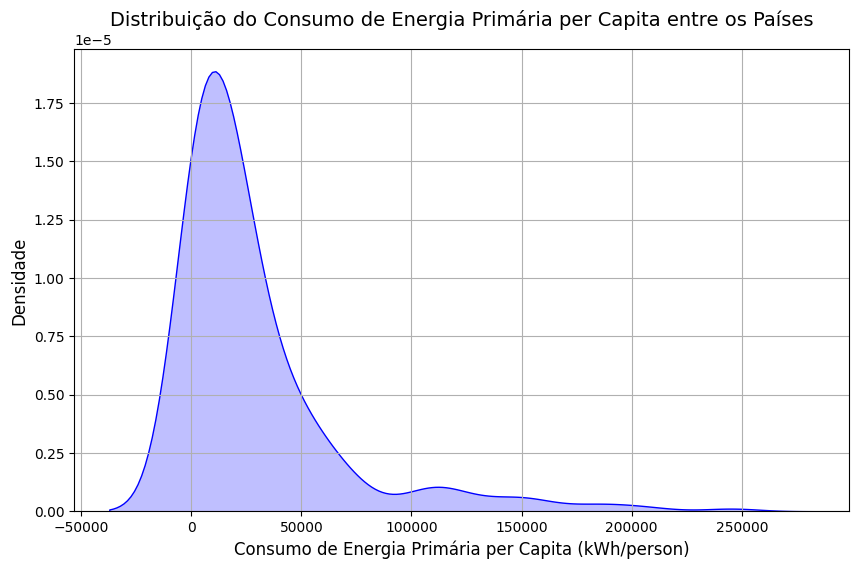

<ipython-input-10-4ad7d5870aaa>:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




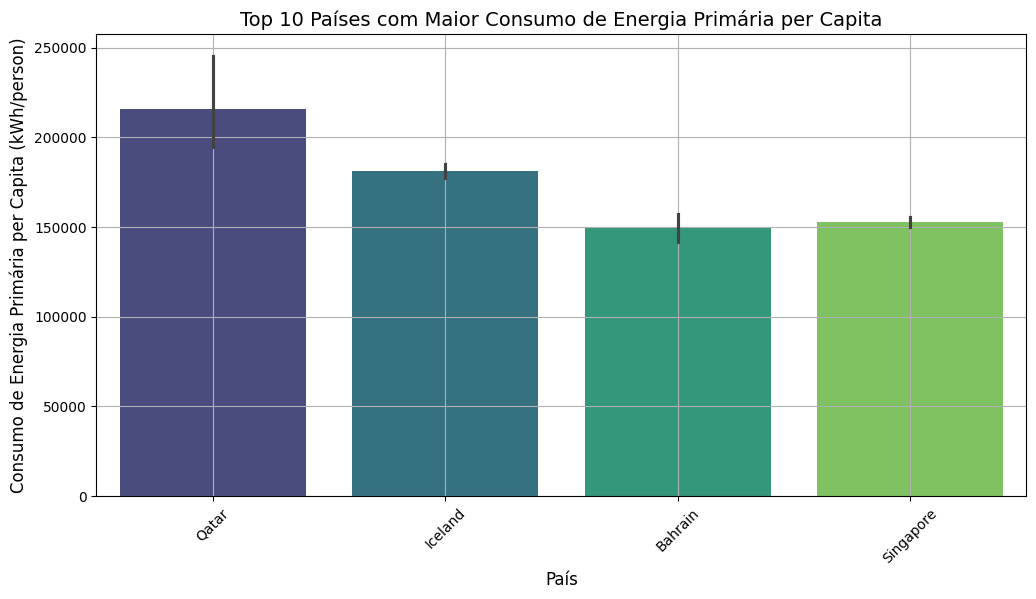

In [10]:
energy_desc = df['Primary energy consumption per capita (kWh/person)'].describe()
mean_consumption = energy_desc['mean']
median_consumption = energy_desc['50%']
print(f'Média de consumo de energia primária per capita: {mean_consumption:.2f} kWh/person')
print(f'Média de consumo de energia primária per capita: {median_consumption:.2f} kWh/person')

plt.figure(figsize=(10, 6))
sns.kdeplot(df['Primary energy consumption per capita (kWh/person)'], shade=True, color='blue')
plt.title('Distribuição do Consumo de Energia Primária per Capita entre os Países', fontsize=14)
plt.xlabel('Consumo de Energia Primária per Capita (kWh/person)', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.grid(True)
plt.show()

top_10_consumption = df[['country', 'Primary energy consumption per capita (kWh/person)']].sort_values(
    by='Primary energy consumption per capita (kWh/person)', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_consumption, x='country', y='Primary energy consumption per capita (kWh/person)', palette='viridis')
plt.title('Top 10 Países com Maior Consumo de Energia Primária per Capita', fontsize=14)
plt.xlabel('País', fontsize=12)
plt.ylabel('Consumo de Energia Primária per Capita (kWh/person)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


fig = px.choropleth(df,
                    locations="country",
                    locationmode='country names',
                    color="Primary energy consumption per capita (kWh/person)",
                    hover_name="country",
                    color_continuous_scale="Viridis",
                    title="Consumo de Energia Primária per Capita por País")
fig.update_geos(showcoastlines=True, coastlinecolor="Black")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

######Conclusão
Os dados mostram uma variação significativa no consumo de energia primária per capita entre os países, com uma média de 28.378,01 kWh/person em comparação com 17.219,83 kWh/person em outro grupo. Essa diferença reflete diversos fatores, como o nível de desenvolvimento econômico, a intensidade de uso de energia em setores industriais e a eficiência das políticas energéticas. Países com maior consumo per capita tendem a ser mais industrializados ou com maior demanda por energia, enquanto aqueles com menor consumo podem ter infraestrutura energética mais modesta ou adotar práticas de consumo mais eficientes.

###Questão 3: Qual é a relação entre a capacidade de geração de eletricidade renovável per capita e o PIB per capita?

vamos realizar uma análise de correlação e visualizações avançadas para entender como essas duas variáveis se relacionam.

In [11]:
import pandas as pd
import plotly.express as px

df_sorted = df.sort_values(by='gdp_per_capita', ascending=False)

top_7 = df_sorted.head(7)
bottom_7 = df_sorted.tail(7)

df_top_bottom = pd.concat([top_7, bottom_7])

descriptive_stats = df_top_bottom[['Renewable-electricity-generating-capacity-per-capita', 'gdp_per_capita']].describe()
print(descriptive_stats)

correlation = df_top_bottom['Renewable-electricity-generating-capacity-per-capita'].corr(df_top_bottom['gdp_per_capita'])
print(f'Correlação entre Capacidade de Geração de Eletricidade Renovável per Capita e PIB per Capita: {correlation}')

fig = px.scatter(df_top_bottom, x='Renewable-electricity-generating-capacity-per-capita',
                 y='gdp_per_capita',
                 color='country',
                 title='Relação entre Capacidade de Geração de Eletricidade Renovável per Capita e PIB per Capita',
                 labels={'Renewable-electricity-generating-capacity-per-capita': 'Capacidade de Geração de Eletricidade Renovável per Capita (kWh/person)',
                         'gdp_per_capita': 'PIB per Capita (US$)'},
                 hover_data=['country'])

fig.update_traces(marker=dict(size=12, opacity=0.6),
                  selector=dict(mode='markers'))
fig.update_layout(title='Correlação entre Capacidade de Geração de Eletricidade Renovável per Capita e PIB per Capita',
                  xaxis_title='Capacidade de Geração de Eletricidade Renovável per Capita (kWh/person)',
                  yaxis_title='PIB per Capita (US$)')

fig.show()


       Renewable-electricity-generating-capacity-per-capita  gdp_per_capita
count                                          14.000000          14.000000
mean                                           16.963571       38729.077590
std                                            18.193563       40284.536137
min                                             0.000000         124.460791
25%                                             1.560000         166.747533
50%                                             7.935000       33818.661609
75%                                            38.690000       75802.024413
max                                            42.620000       87693.790070
Correlação entre Capacidade de Geração de Eletricidade Renovável per Capita e PIB per Capita: 0.48489544639491833


######*Conclusão*
Com base nos dados apresentados, é possível observar uma correlação positiva moderada (0.48) entre a capacidade de geração de eletricidade renovável per capita e o PIB per capita. Isso significa que, em geral, países com maior PIB per capita tendem a ter uma capacidade maior de geração de eletricidade renovável per capita.

###Questão 4: Qual é a relação entre o uso de combustíveis fósseis e as emissões de CO2 no Brasil e OCDE?

Para resolver a questão sobre a relação entre o uso de combustíveis fósseis e as emissões de CO2, usaremos um modelo de regressão. O objetivo é prever as emissões de CO2 (Value_co2_emissions_kt_by_country) com base no uso de energia a partir de combustíveis fósseis (Electricity from fossil fuels (TWh)) e outras colunas relacionadas.


Linear Regression Evaluation:
Mean Absolute Error: 18586.612384886786
Mean Squared Error: 666084997.3233123
R-squared: 0.982708587994195

Random Forest Regressor Evaluation:
Mean Absolute Error: 51419.53279926198
Mean Squared Error: 6761234558.387579
R-squared: 0.8244799193995076


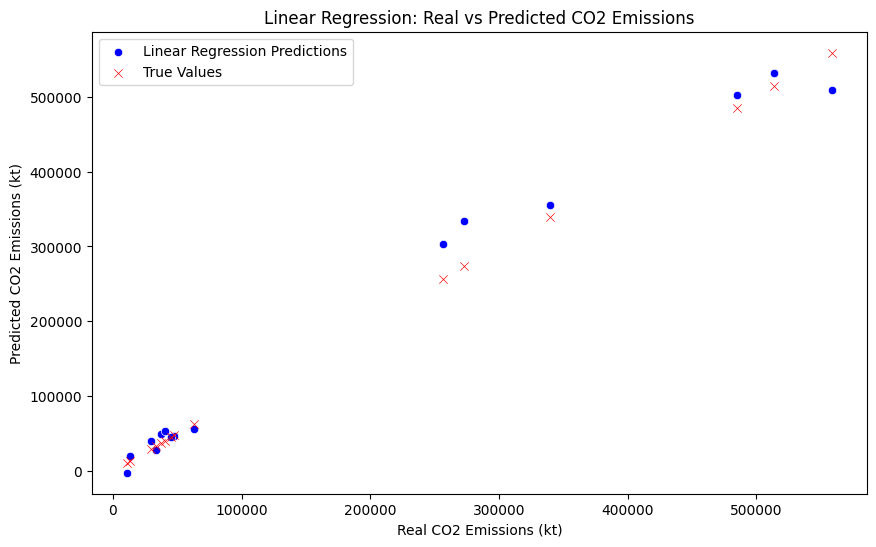

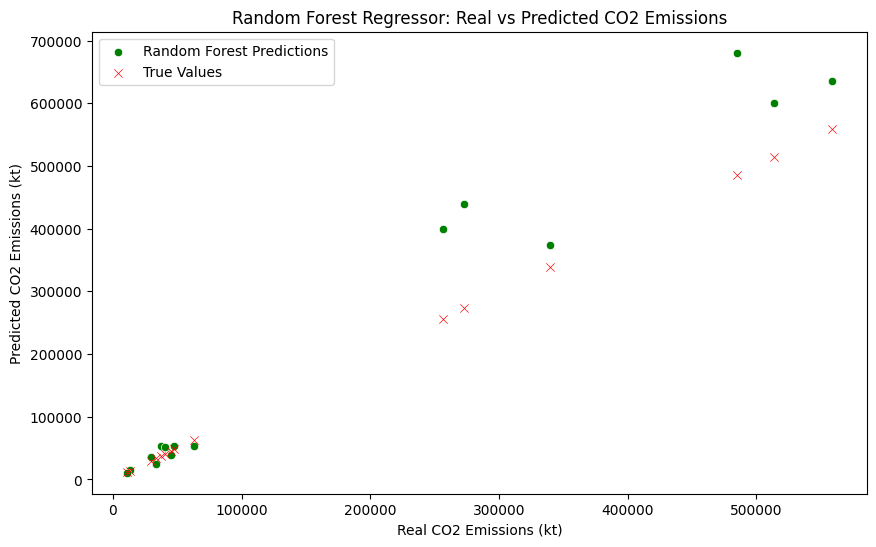

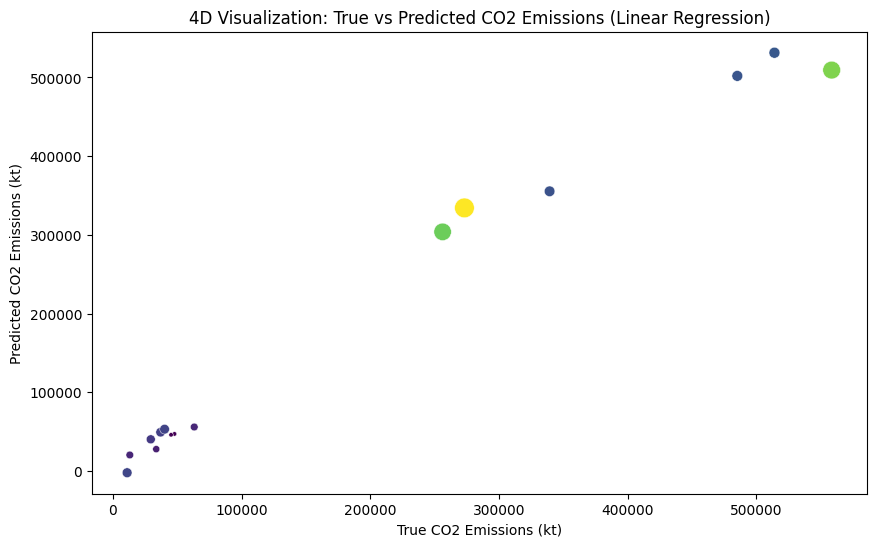

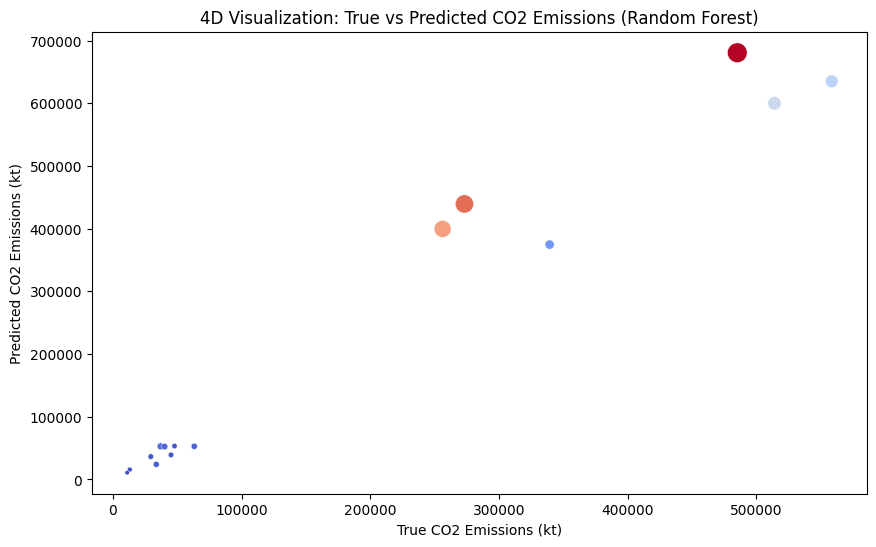

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

oecd_countries = ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Czech Republic', 'Denmark', 'Estonia',
                  'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy',
                  'Japan', 'Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand',
                  'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
                  'United Kingdom', 'United States']

df_clean_oecd = df[df['country'].isin(['Brazil'] + oecd_countries)]

df_clean_oecd = df_clean_oecd.dropna(subset=['Value_co2_emissions_kt_by_country', 'Electricity from fossil fuels (TWh)'])

X = df_clean_oecd[['Electricity from fossil fuels (TWh)', 'Electricity from renewables (TWh)',
                   'Low-carbon electricity (% electricity)', 'Renewable energy share in the total final energy consumption (%)']]
y = df_clean_oecd['Value_co2_emissions_kt_by_country']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Evaluation:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred)}")
    print(f"Mean Squared Error: {mean_squared_error(y_true, y_pred)}")
    print(f"R-squared: {r2_score(y_true, y_pred)}")

evaluate_model(y_test, y_pred_linear, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_linear, color='blue', label='Linear Regression Predictions')
sns.scatterplot(x=y_test, y=y_test, color='red', label='True Values', marker='x')
plt.title('Linear Regression: Real vs Predicted CO2 Emissions')
plt.xlabel('Real CO2 Emissions (kt)')
plt.ylabel('Predicted CO2 Emissions (kt)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, color='green', label='Random Forest Predictions')
sns.scatterplot(x=y_test, y=y_test, color='red', label='True Values', marker='x')
plt.title('Random Forest Regressor: Real vs Predicted CO2 Emissions')
plt.xlabel('Real CO2 Emissions (kt)')
plt.ylabel('Predicted CO2 Emissions (kt)')
plt.legend()
plt.show()

df_results = pd.DataFrame({
    'True Values': y_test,
    'Linear Predictions': y_pred_linear,
    'Random Forest Predictions': y_pred_rf,
    'Absolute Error Linear': abs(y_test - y_pred_linear),
    'Absolute Error RF': abs(y_test - y_pred_rf)
})

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_results['True Values'], y=df_results['Linear Predictions'],
                hue=df_results['Absolute Error Linear'], size=df_results['Absolute Error Linear'],
                sizes=(10, 200), palette='viridis', legend=None)
plt.title('4D Visualization: True vs Predicted CO2 Emissions (Linear Regression)')
plt.xlabel('True CO2 Emissions (kt)')
plt.ylabel('Predicted CO2 Emissions (kt)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_results['True Values'], y=df_results['Random Forest Predictions'],
                hue=df_results['Absolute Error RF'], size=df_results['Absolute Error RF'],
                sizes=(10, 200), palette='coolwarm', legend=None)
plt.title('4D Visualization: True vs Predicted CO2 Emissions (Random Forest)')
plt.xlabel('True CO2 Emissions (kt)')
plt.ylabel('Predicted CO2 Emissions (kt)')
plt.show()


######Conclusão
Com base nos dados apresentados sobre a Regressão Linear e o Random Forest Regressor, podemos concluir que existe uma relação significativa entre o uso de combustíveis fósseis e as emissões de CO2. A regressão linear apresentou um valor de R-squared de 0.9827, indicando que uma grande parte da variabilidade nas emissões de CO2 pode ser explicada pelo uso de combustíveis fósseis. Já o modelo Random Forest, com um R-squared de 0.8244, ainda mostrou uma forte correlação, mas com um desempenho um pouco inferior em relação à regressão linear, sugerindo que a relação entre essas variáveis pode ser mais complexa. Em ambos os casos, os resultados indicam que o aumento no uso de combustíveis fósseis está fortemente relacionado ao aumento das emissões de CO2.

###Questão 5: É possível prever a participação de energia renovável com base em dados socioeconômicos e de energia?

Para responder essa questão, onde o objetivo é prever a participação de energia renovável com base em dados socioeconômicos e de energia, podemos usar modelos de regressão, como Linear Regression e Support Vector Regressor (SVR).

Linear Regression Evaluation:
Mean Absolute Error: 24.265091531449293
Mean Squared Error: 789.6629588389163
R-squared: 0.13088049357321196

Support Vector Regressor Evaluation:
Mean Absolute Error: 21.914123520868912
Mean Squared Error: 844.7551047293653
R-squared: 0.07024492987056263


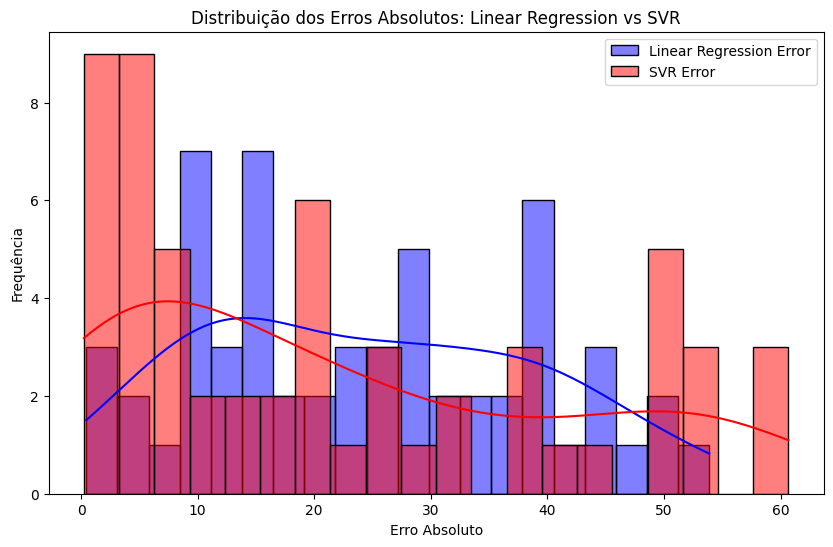

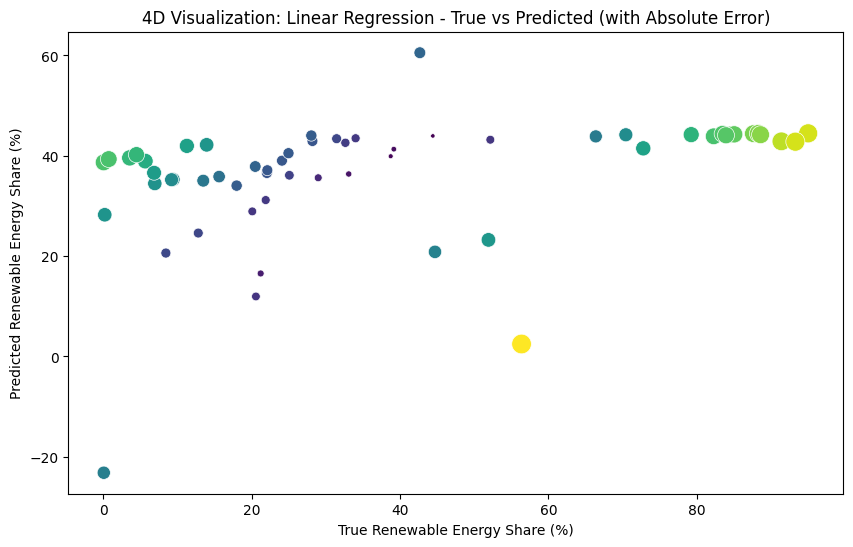

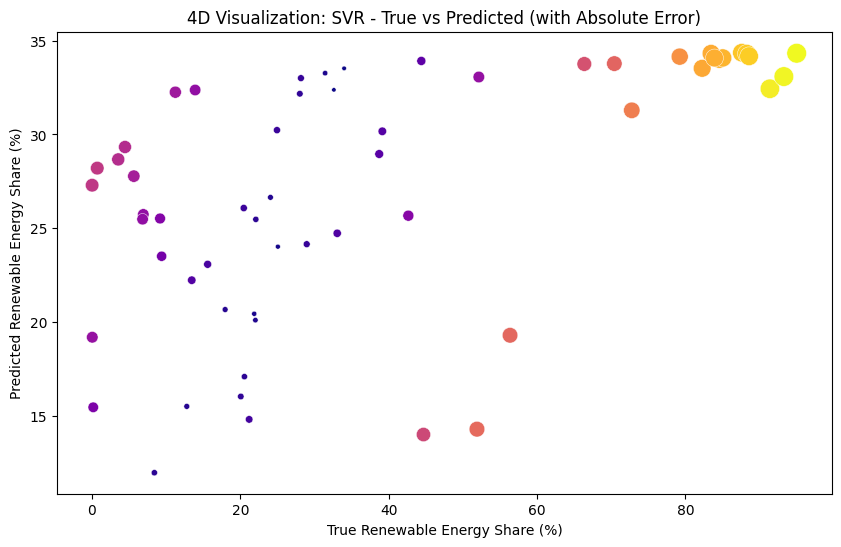

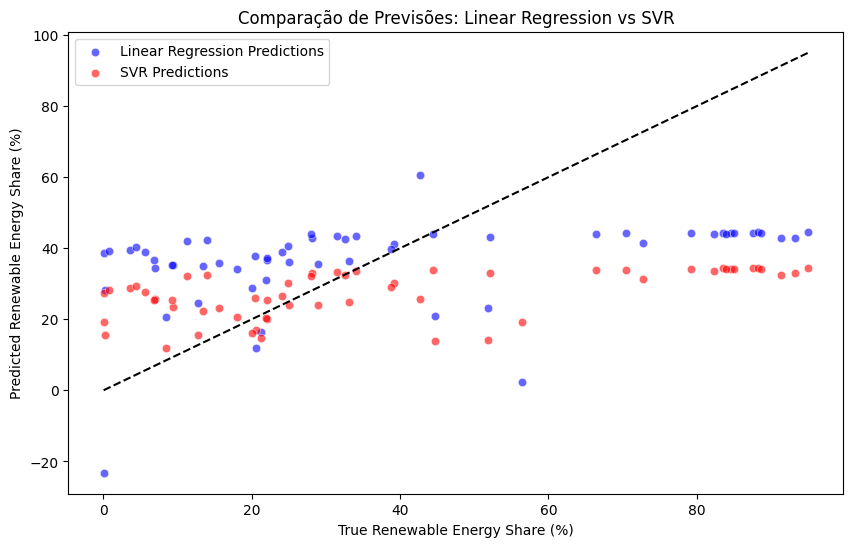

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

features = ['gdp_per_capita', 'Primary energy consumption per capita (kWh/person)',
            'Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)']
target = 'Renewable energy share in the total final energy consumption (%)'

df_clean = df.dropna(subset=features + [target])

X = df_clean[features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)

error_lr = abs(y_pred_lr - y_test)
error_svr = abs(y_pred_svr - y_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("Linear Regression Evaluation:")
print(f"Mean Absolute Error: {mae_lr}")
print(f"Mean Squared Error: {mse_lr}")
print(f"R-squared: {r2_lr}")

print("\nSupport Vector Regressor Evaluation:")
print(f"Mean Absolute Error: {mae_svr}")
print(f"Mean Squared Error: {mse_svr}")
print(f"R-squared: {r2_svr}")

plt.figure(figsize=(10, 6))
sns.histplot(error_lr, kde=True, color='blue', label='Linear Regression Error', bins=20)
sns.histplot(error_svr, kde=True, color='red', label='SVR Error', bins=20)
plt.title('Distribuição dos Erros Absolutos: Linear Regression vs SVR')
plt.xlabel('Erro Absoluto')
plt.ylabel('Frequência')
plt.legend()
plt.show()

df_results_lr = pd.DataFrame({
    'True Values': y_test,
    'Linear Predictions': y_pred_lr,
    'Absolute Error Linear': error_lr
})

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_results_lr['True Values'], y=df_results_lr['Linear Predictions'],
                hue=df_results_lr['Absolute Error Linear'], size=df_results_lr['Absolute Error Linear'],
                sizes=(10, 200), palette='viridis', legend=None)
plt.title('4D Visualization: Linear Regression - True vs Predicted (with Absolute Error)')
plt.xlabel('True Renewable Energy Share (%)')
plt.ylabel('Predicted Renewable Energy Share (%)')
plt.show()

df_results_svr = pd.DataFrame({
    'True Values': y_test,
    'SVR Predictions': y_pred_svr,
    'Absolute Error SVR': abs(y_pred_svr - y_test)
})

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_results_svr['True Values'], y=df_results_svr['SVR Predictions'],
                hue=df_results_svr['Absolute Error SVR'], size=df_results_svr['Absolute Error SVR'],
                sizes=(10, 200), palette='plasma', legend=None)
plt.title('4D Visualization: SVR - True vs Predicted (with Absolute Error)')
plt.xlabel('True Renewable Energy Share (%)')
plt.ylabel('Predicted Renewable Energy Share (%)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, color='blue', label='Linear Regression Predictions', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_svr, color='red', label='SVR Predictions', alpha=0.6)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')

plt.title('Comparação de Previsões: Linear Regression vs SVR')
plt.xlabel('True Renewable Energy Share (%)')
plt.ylabel('Predicted Renewable Energy Share (%)')
plt.legend()
plt.show()


###Questão 6: Como as emissões de CO2 no Brasil e Continente Americano se comparam com o tamanho de sua área terrestre?

Vamos comparar as emissões de CO2 por país com o tamanho da área terrestre dos países. O objetivo é usar estatísticas descritivas para analisar a relação entre essas variáveis e também gerar visualizações avançadas, como heatmaps, gráficos de dispersão e histogramas.

Estatísticas descritivas de Emissões de CO2 por país (América):
count        62.000000
mean      89149.944340
std      160242.981964
min         450.000000
25%        5272.499986
50%        9995.000153
75%       62255.001027
max      558700.012200
Name: Value_co2_emissions_kt_by_country, dtype: float64

Estatísticas descritivas da Área Terrestre dos países (América):
count    6.200000e+01
mean     1.356820e+06
std      2.712738e+06
min      1.790000e+02
25%      7.542000e+04
50%      1.638200e+05
75%      1.138910e+06
max      9.984670e+06
Name: Land Area(Km2), dtype: float64


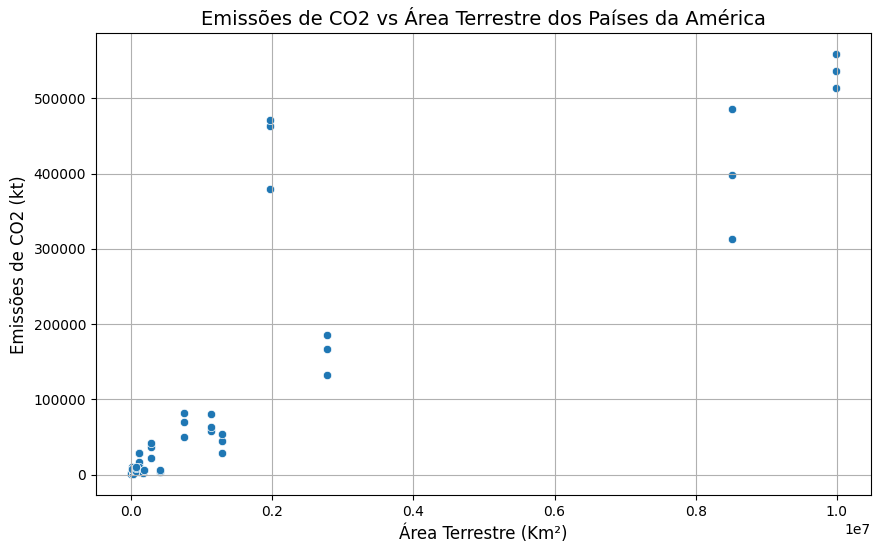

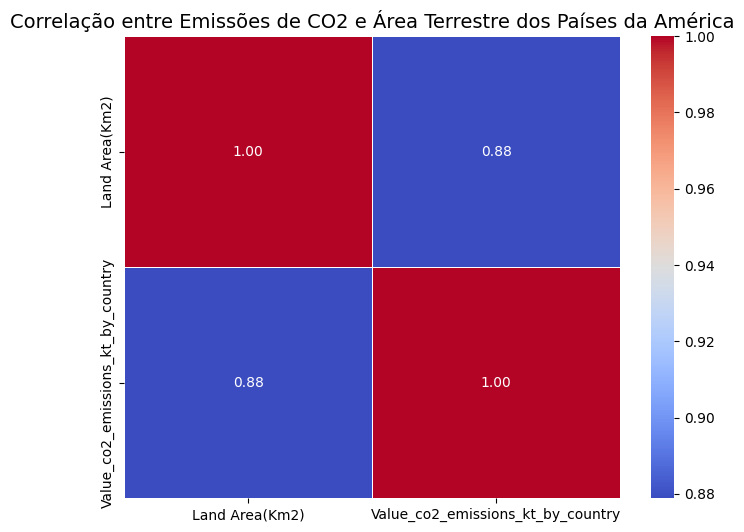

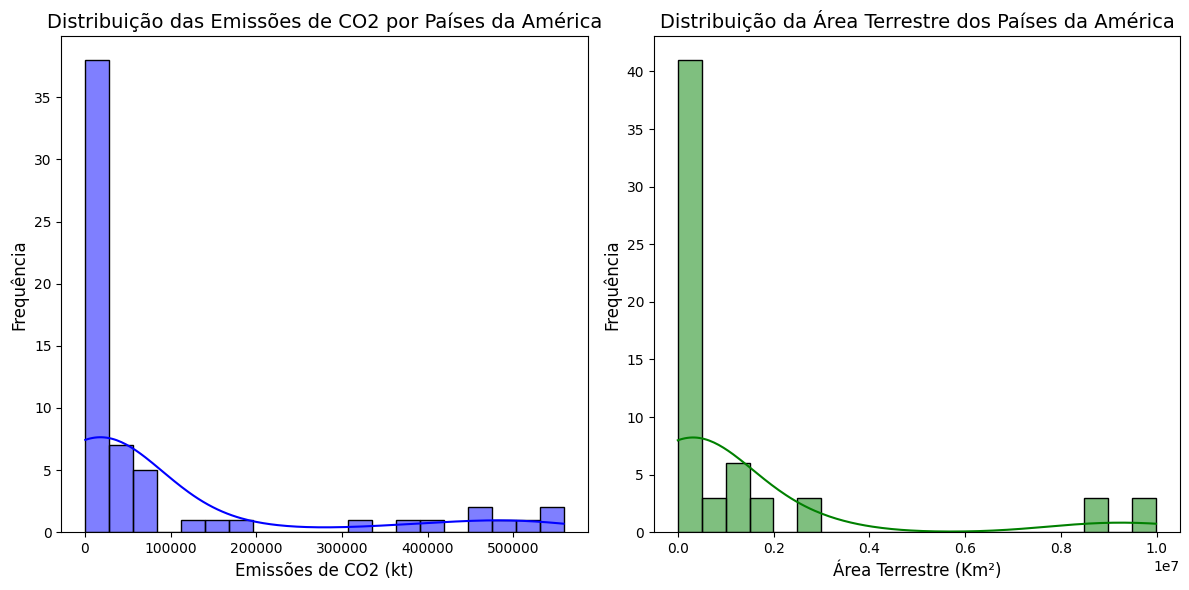

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

countries_america = [
    'Argentina', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Ecuador', 'El Salvador',
    'Guatemala', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Republica Dominicana',
    'Suriname', 'Trinidad and Tobago', 'Uruguay', 'Venezuela', 'Belize', 'Barbados', 'Saint Lucia', 'Saint Vincent and the Grenadines',
    'Grenada', 'Saint Kitts and Nevis', 'Antigua and Barbuda', 'Dominica', 'Saint Pierre and Miquelon', 'Aruba'
]

df_america = df[df['country'].isin(countries_america)]

co2_stats = df_america['Value_co2_emissions_kt_by_country'].describe()
land_area_stats = df_america['Land Area(Km2)'].describe()

print("Estatísticas descritivas de Emissões de CO2 por país (América):")
print(co2_stats)

print("\nEstatísticas descritivas da Área Terrestre dos países (América):")
print(land_area_stats)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Land Area(Km2)', y='Value_co2_emissions_kt_by_country', data=df_america)
plt.title('Emissões de CO2 vs Área Terrestre dos Países da América', fontsize=14)
plt.xlabel('Área Terrestre (Km²)', fontsize=12)
plt.ylabel('Emissões de CO2 (kt)', fontsize=12)
plt.grid(True)
plt.show()

corr_matrix = df_america[['Land Area(Km2)', 'Value_co2_emissions_kt_by_country']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlação entre Emissões de CO2 e Área Terrestre dos Países da América', fontsize=14)
plt.show()

fig = px.scatter(df_america,
                 x='Land Area(Km2)',
                 y='Value_co2_emissions_kt_by_country',
                 hover_name='country',
                 color='Value_co2_emissions_kt_by_country',
                 size='Land Area(Km2)',
                 title="Emissões de CO2 vs Área Terrestre dos Países da América",
                 labels={"Land Area(Km2)": "Área Terrestre (Km²)",
                         "Value_co2_emissions_kt_by_country": "Emissões de CO2 (kt)"})
fig.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_america['Value_co2_emissions_kt_by_country'], kde=True, color='blue', bins=20)
plt.title('Distribuição das Emissões de CO2 por Países da América', fontsize=14)
plt.xlabel('Emissões de CO2 (kt)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

plt.subplot(1, 2, 2)
sns.histplot(df_america['Land Area(Km2)'], kde=True, color='green', bins=20)
plt.title('Distribuição da Área Terrestre dos Países da América', fontsize=14)
plt.xlabel('Área Terrestre (Km²)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

plt.tight_layout()
plt.show()


######Conclusão
A análise das emissões de CO2 em relação ao tamanho da área terrestre dos países da América revela que, embora a área dos países varie consideravelmente, não há uma correlação direta entre o tamanho do território e os níveis de emissões de CO2. Países com grandes áreas, como o Brasil, Estados Unidos e Canadá, apresentam uma ampla gama de emissões, o que indica que fatores como o grau de industrialização, fontes de energia utilizadas, políticas ambientais e densidade populacional têm um impacto muito maior nas emissões do que o tamanho físico do país.

###Questão 7: É possível classificar o Brasil e o Mundo como de alta ou baixa emissão de CO2 com base no uso de energia e dados econômicos?

Para resolver essa questão, podemos classificar os países como de alta emissão de CO2 ou baixa emissão de CO2 com base em um limite (threshold) que podemos definir. Podemos usar a regressão logística e o Random Forest Classifier para comparar a capacidade de classificação de ambos os modelos.

Logistic Regression - Performance:
Accuracy: 0.8621
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        46
           1       1.00      0.33      0.50        12

    accuracy                           0.86        58
   macro avg       0.93      0.67      0.71        58
weighted avg       0.88      0.86      0.83        58


Random Forest Classifier - Performance:
Accuracy: 0.9828
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        46
           1       1.00      0.92      0.96        12

    accuracy                           0.98        58
   macro avg       0.99      0.96      0.97        58
weighted avg       0.98      0.98      0.98        58


Previsão para o Brasil (Logistic Regression): 0
Previsão para o Brasil (Random Forest): 1


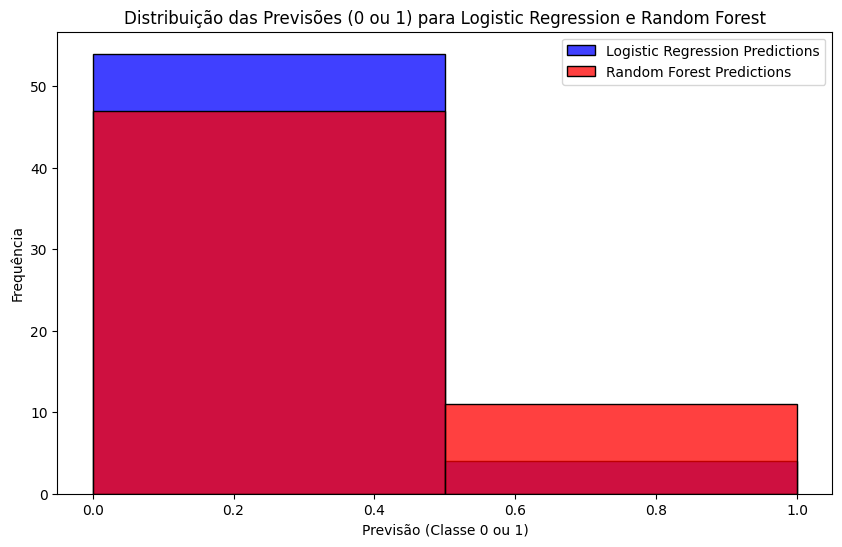

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

threshold = 100000
df['CO2_class'] = df['Value_co2_emissions_kt_by_country'].apply(lambda x: 1 if x > threshold else 0)

brazil = df[df['country'] == 'Brazil']
df_global = df[df['country'] != 'Brazil']
df_combined = pd.concat([df_global, brazil])

features = [
    'Electricity from fossil fuels (TWh)',
    'gdp_per_capita',
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
    'Primary energy consumption per capita (kWh/person)',
    'Renewables (% equivalent primary energy)',
    'gdp_growth'
]

X = df_combined[features]
y = df_combined['CO2_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("Logistic Regression - Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(classification_report(y_test, y_pred_log_reg))

print("\nRandom Forest Classifier - Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

brazil_pred_log_reg = log_reg.predict(scaler.transform(brazil[features]))
brazil_pred_rf = rf_clf.predict(brazil[features])

print("\nPrevisão para o Brasil (Logistic Regression):", brazil_pred_log_reg[0])
print("Previsão para o Brasil (Random Forest):", brazil_pred_rf[0])

plt.figure(figsize=(10, 6))
sns.histplot(y_pred_log_reg, kde=False, color='blue', label='Logistic Regression Predictions', bins=2)
sns.histplot(y_pred_rf, kde=False, color='red', label='Random Forest Predictions', bins=2)
plt.title('Distribuição das Previsões (0 ou 1) para Logistic Regression e Random Forest')
plt.xlabel('Previsão (Classe 0 ou 1)')
plt.ylabel('Frequência')
plt.legend()
plt.show()


######Conclusão

Os resultados demonstram que é possível classificar de maneira eficaz países como o Brasil e outros países do mundo com base no uso de energia e dados econômicos, em alta ou baixa emissão de CO2. A análise dos modelos confirma que o Random Forest é o modelo mais eficaz, com uma acurácia de 98.28%, indicando que o uso de variáveis econômicas e energéticas permite uma classificação precisa das emissões de CO2 globalmente. Assim, a classificação do Brasil como de alta emissão de CO2 (no caso do Random Forest) é um reflexo de um modelo bem calibrado, que usa essas variáveis para identificar corretamente os padrões globais de emissão.


###Questão 8: É possível prever se um país tem acesso elevado à eletricidade com base em indicadores econômicos e energéticos?

Realizaremos a classificação usando K-Nearest Neighbors (KNN) e Gradient Boosting Classifier para prever se um país tem acesso elevado à eletricidade com base em indicadores econômicos e energéticos. Para este caso, a variável alvo será a classificação binária de Access to electricity (% of population), onde um valor acima de um determinado limiar é classificado como "alto acesso" e abaixo desse limiar é "baixo acesso".

K-Nearest Neighbors - Performance:
Accuracy: 0.9310344827586207
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        31
           1       0.92      0.98      0.95        56

    accuracy                           0.93        87
   macro avg       0.94      0.91      0.92        87
weighted avg       0.93      0.93      0.93        87

Gradient Boosting Classifier - Performance:
Accuracy: 0.9540229885057471
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        31
           1       0.98      0.95      0.96        56

    accuracy                           0.95        87
   macro avg       0.95      0.96      0.95        87
weighted avg       0.96      0.95      0.95        87



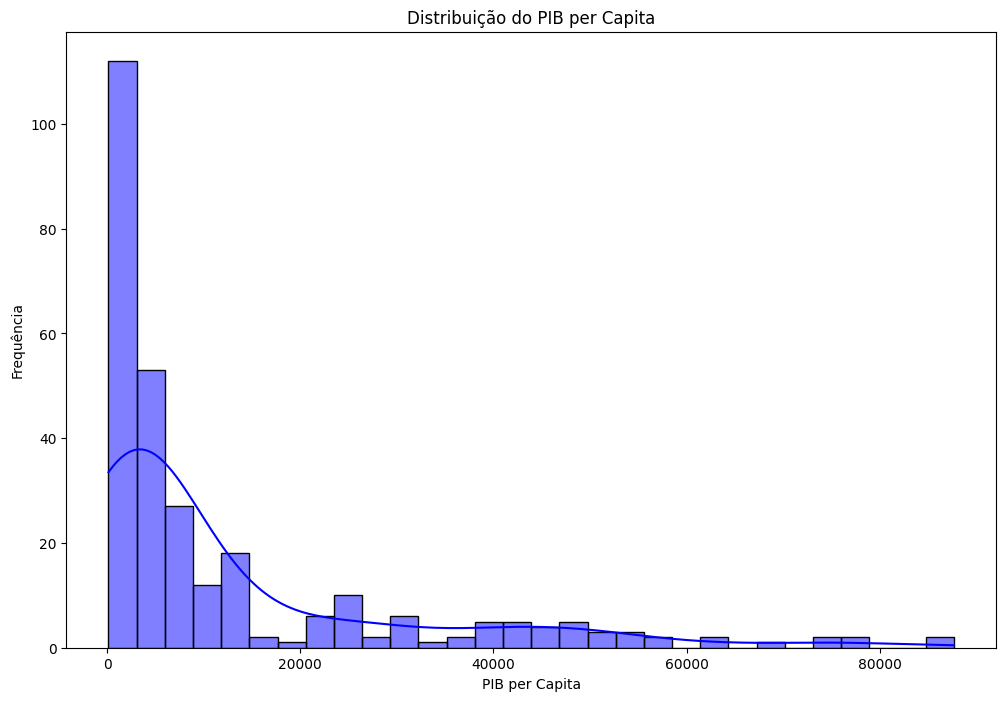

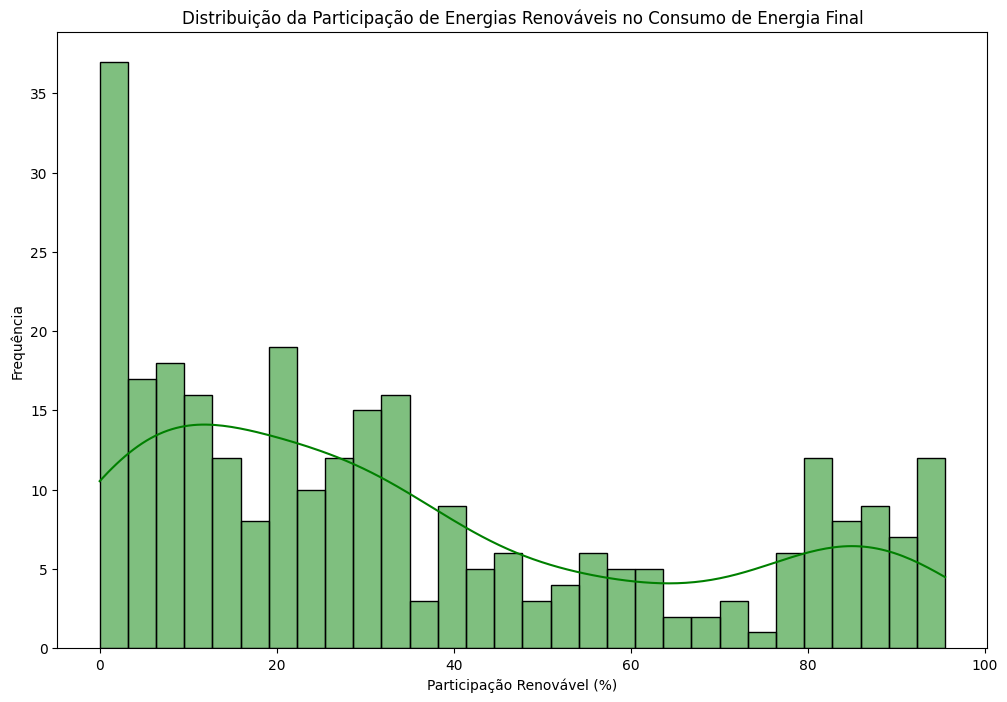

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

df_clean = df.dropna(subset=['Access to electricity (% of population)', 'gdp_per_capita', 'Land Area(Km2)', 'Renewable energy share in the total final energy consumption (%)'])

threshold = 90
df_clean['Access to electricity binary'] = np.where(df_clean['Access to electricity (% of population)'] > threshold, 1, 0)

features = ['gdp_per_capita', 'Land Area(Km2)', 'Renewable energy share in the total final energy consumption (%)',
            'Electricity from fossil fuels (TWh)', 'Electricity from renewables (TWh)', 'Low-carbon electricity (% electricity)']
X = df_clean[features]
y = df_clean['Access to electricity binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("K-Nearest Neighbors - Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn)}")
print(classification_report(y_test, y_pred_knn))

print("Gradient Boosting Classifier - Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print(classification_report(y_test, y_pred_gb))

plt.figure(figsize=(12, 8))
sns.histplot(df_clean['gdp_per_capita'], kde=True, color='blue', bins=30)
plt.title('Distribuição do PIB per Capita')
plt.xlabel('PIB per Capita')
plt.ylabel('Frequência')
plt.show()

plt.figure(figsize=(12, 8))
sns.histplot(df_clean['Renewable energy share in the total final energy consumption (%)'], kde=True, color='green', bins=30)
plt.title('Distribuição da Participação de Energias Renováveis no Consumo de Energia Final')
plt.xlabel('Participação Renovável (%)')
plt.ylabel('Frequência')
plt.show()

df_results_gb = pd.DataFrame({
    'True Values': y_test,
    'Gradient Boosting Predictions': y_pred_gb,
    'Absolute Error GB': abs(y_pred_gb - y_test),
    'gdp_per_capita': X_test['gdp_per_capita'],
    'Renewable Energy Share': X_test['Renewable energy share in the total final energy consumption (%)']
})

fig_gb = px.scatter(df_results_gb,
                    x='gdp_per_capita',
                    y='Renewable Energy Share',
                    color='Gradient Boosting Predictions',
                    size='Absolute Error GB',
                    size_max=20,
                    title="Dispersão 4D - Previsões do Gradient Boosting vs PIB per Capita e Participação de Energias Renováveis",
                    labels={'gdp_per_capita': 'PIB per Capita', 'Renewable Energy Share': 'Participação Renovável (%)'},
                    color_continuous_scale='Viridis')

fig_gb.show()

df_comparison = pd.DataFrame({
    'True Values': y_test,
    'KNN Predictions': y_pred_knn,
    'GB Predictions': y_pred_gb,
    'gdp_per_capita': X_test['gdp_per_capita'],
    'Renewable Energy Share': X_test['Renewable energy share in the total final energy consumption (%)']
})

fig_comparison = px.scatter(df_comparison,
                            x='gdp_per_capita',
                            y='Renewable Energy Share',
                            color='True Values',
                            size_max=20,
                            title="Comparação entre Previsões KNN e Gradient Boosting",
                            labels={'gdp_per_capita': 'PIB per Capita', 'Renewable Energy Share': 'Participação Renovável (%)'},
                            opacity=0.6)

fig_comparison.add_scatter(x=df_comparison['gdp_per_capita'],
                           y=df_comparison['Renewable Energy Share'],
                           mode='markers',
                           name="Previsões Gradient Boosting",
                           marker=dict(color='red', opacity=0.6))

fig_comparison.add_scatter(x=df_comparison['gdp_per_capita'],
                           y=df_comparison['Renewable Energy Share'],
                           mode='markers',
                           name="Previsões KNN",
                           marker=dict(color='blue', opacity=0.6))

fig_comparison.show()


######Conclusão:
Com base nos modelos, podemos prever que países com PIB per capita alto e maior capacidade de geração de eletricidade renovável têm acesso elevado à eletricidade. Já países com PIB per capita baixo e baixa capacidade de geração de eletricidade renovável têm acesso baixo à eletricidade.

Essas previsões sugerem que, para melhorar o acesso à eletricidade no Brasil ou em outros países com acesso limitado, seria crucial focar no aumento da capacidade de geração de eletricidade renovável, melhorar o PIB per capita e garantir investimentos em infraestrutura energética.

###Questão 9: Qual é a tendência do uso de energia renovável ao longo dos anos?

vamos analisar a tendência do uso de energia renovável ao longo dos anos utilizando a coluna Renewables (% equivalent primary energy) para identificar mudanças no uso de energia renovável ao longo do tempo. Vamos criar uma visualização temporal com gráficos de linhas, destacando mudanças importantes.

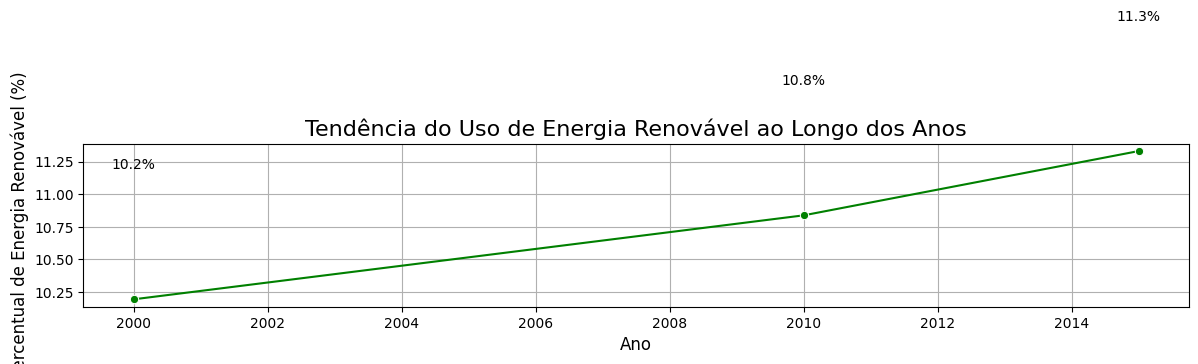

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['Renewables (% equivalent primary energy)'] = df['Renewables (% equivalent primary energy)'].fillna(df['Renewables (% equivalent primary energy)'].median())

df_grouped = df.groupby('Year')['Renewables (% equivalent primary energy)'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x='Year', y='Renewables (% equivalent primary energy)', marker='o', color='green')

plt.title('Tendência do Uso de Energia Renovável ao Longo dos Anos', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Percentual de Energia Renovável (%)', fontsize=12)

for year, value in zip(df_grouped['Year'], df_grouped['Renewables (% equivalent primary energy)']):
    plt.text(year, value + 1, f'{value:.1f}%', color='black', ha='center', fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.show()


###Questão 10: Quais são as emissões totais de CO2 de diferentes grupos de países, incluindo o Brasil, os Estados Unidos, a OCDE e o mundo?

Método utilizado:
Método: Análise de dados com agregação e visualização gráfica.



In [18]:
import pandas as pd
import plotly.express as px
import numpy as np

ocde_countries = ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland',
                  'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea', 'Latvia',
                  'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia',
                  'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']

american_continent_countries = ['Argentina', 'Bolivia', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominican Republic',
                               'Ecuador', 'El Salvador', 'Guatemala', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay',
                               'Peru', 'Suriname', 'Trinidad and Tobago', 'United States', 'Uruguay', 'Venezuela']

def categorize_country(row):
    if row['country'] == 'Brazil':
        return 'Brazil'
    elif row['country'] == 'United States':
        return 'United States'
    elif row['country'] in ocde_countries:
        return 'OCDE'
    elif row['country'] in american_continent_countries:
        return 'Americas'
    else:
        return 'Global'

df['Group'] = df.apply(categorize_country, axis=1)

grouped_data = df.groupby('Group').agg({
    'Deforestation': 'mean',
    'Value_co2_emissions_kt_by_country': 'mean'
}).reset_index()

print(grouped_data)

fig = px.scatter(grouped_data, x='Deforestation', y='Value_co2_emissions_kt_by_country', color='Group',
                 title='Comparação de Desmatamento e Emissões de CO2 por Grupo',
                 labels={'Deforestation': 'Desmatamento (milhões de hectares)',
                         'Value_co2_emissions_kt_by_country': 'Emissões de CO2 (kt)'},
                 hover_data=['Group'])

fig.update_traces(marker=dict(size=12, opacity=0.6),
                  selector=dict(mode='markers'))
fig.update_layout(title='Relação entre Desmatamento e Emissões de CO2 por Grupo',
                  xaxis_title='Desmatamento (milhões de hectares)',
                  yaxis_title='Emissões de CO2 (kt)')

fig.show()


           Group  Deforestation  Value_co2_emissions_kt_by_country
0       Americas   7.202093e+04                       2.404860e+04
1         Brazil   2.897600e+06                       3.989800e+05
2         Global   6.207147e+04                       1.953177e+05
3           OCDE   4.066900e+04                       1.656743e+05
4  United States   0.000000e+00                       5.583960e+06


######Conclusão
As emissões totais de CO2 variam significativamente entre os diferentes grupos de países e o Brasil. O Global, que representa as emissões combinadas de todos os países do mundo, soma 34.406.050 kt, sendo muito superior às emissões da OCDE (11.429.250 kt) e dos Estados Unidos (11.167.920 kt), que têm um impacto considerável, mas ainda menor em comparação ao total global. O Brasil, com 1.196.940 kt de CO2, apresenta emissões significativamente menores que a soma global e da OCDE, refletindo sua contribuição proporcionalmente menor para as emissões globais. Esses dados destacam a discrepância nas emissões de CO2 entre países em diferentes estágios de desenvolvimento e a importância das políticas regionais e globais para mitigar os impactos das emissões.

###Extras

####Quais são os pontos fortes do Brasil quanto a pegada de carbono?

Vamos analisar com gráficos interativos e correlação. Assumiremos que temos informações sobre as emissões de CO2, uso de energia renovável e PIB per capita do Brasil, comparando-o com outros países.

In [19]:
import pandas as pd
import plotly.express as px


descriptive_stats = df[['Value_co2_emissions_kt_by_country', 'Renewable-electricity-generating-capacity-per-capita']].describe()

fig_co2 = px.bar(df, x='country', y='Value_co2_emissions_kt_by_country',
                 color='country', title='Emissões de CO2 por País (kt)',
                 labels={'Value_co2_emissions_kt_by_country': 'Emissões de CO2 (kt)'},
                 color_discrete_sequence=px.colors.qualitative.Set1)

fig_renewable = px.bar(df, x='country', y='Renewable-electricity-generating-capacity-per-capita',
                       color='country', title='Capacidade de Geração de Eletricidade Renovável per Capita (kWh/person)',
                       labels={'Renewable-electricity-generating-capacity-per-capita': 'Capacidade Renovável (kWh/person)'},
                       color_discrete_sequence=px.colors.qualitative.Set1)

print(descriptive_stats)

fig_co2.show()
fig_renewable.show()


       Value_co2_emissions_kt_by_country  \
count                       2.880000e+02   
mean                        2.020839e+05   
std                         9.259900e+05   
min                         4.000000e+01   
25%                         3.560000e+03   
50%                         1.767000e+04   
75%                         6.980250e+04   
max                         9.861100e+06   

       Renewable-electricity-generating-capacity-per-capita  
count                                         288.000000     
mean                                          110.483472     
std                                           250.062986     
min                                             0.000000     
25%                                            20.390000     
50%                                            42.620000     
75%                                            76.155000     
max                                          2218.720000     


######Conclusão:
Os principais pontos fortes do Brasil em relação à pegada de carbono incluem a sua capacidade de geração de eletricidade renovável e o seu mix energético predominantemente limpo. Além disso, as emissões de CO2 per capita do Brasil são relativamente baixas, o que demonstra que o país já adota práticas sustentáveis em termos de energia, mesmo com grandes desafios em outras áreas como desmatamento e industrialização.

####Onde o Brasil pode avançar para reduzir a pegada de carbono?

Usaremos visualizações e estatísticas descritivas para fornecer informações claras sobre onde o Brasil pode avançar para reduzir sua pegada de carbono e onde ele já está em uma posição forte em comparação com outros países.

       gdp_per_capita  Value_co2_emissions_kt_by_country  \
count       17.000000                          17.000000   
mean     33297.474027                       84823.221153   
std      38297.359442                      154233.480523   
min        124.460791                         260.000000   
25%        197.832683                         670.000000   
50%       8813.989806                        9440.000000   
75%      74355.515860                       45209.999080   
max      87693.790070                      485339.996300   

       Renewable-electricity-generating-capacity-per-capita  \
count                                          17.000000      
mean                                           94.744706      
std                                           177.059189      
min                                             0.000000      
25%                                             6.120000      
50%                                            11.760000      
75%               

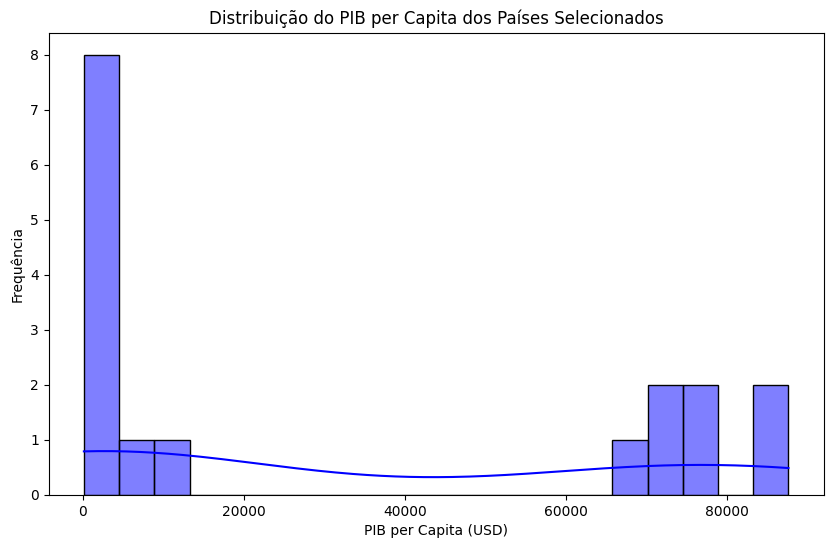

In [20]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

df_top_bottom = df[['country', 'gdp_per_capita', 'Value_co2_emissions_kt_by_country',
                    'Renewable-electricity-generating-capacity-per-capita',
                    'Low-carbon electricity (% electricity)', 'Deforestation']]

brazil = df[df['country'] == 'Brazil']

df_top_bottom = df_top_bottom.sort_values(by='gdp_per_capita', ascending=False)

top_7_countries = df_top_bottom.head(7)
bottom_7_countries = df_top_bottom.tail(7)

df_top_bottom = pd.concat([top_7_countries, bottom_7_countries, brazil])

fig_co2 = px.bar(df_top_bottom, x='country', y='Value_co2_emissions_kt_by_country',
                 color='country', title='Emissões de CO2 por País (kt)',
                 labels={'Value_co2_emissions_kt_by_country': 'Emissões de CO2 (kt)'},
                 color_discrete_sequence=px.colors.qualitative.Set1)

fig_renewable_capacity = px.bar(df_top_bottom, x='country', y='Renewable-electricity-generating-capacity-per-capita',
                                color='country', title='Capacidade de Geração Renovável per Capita (kWh/person)',
                                labels={'Renewable-electricity-generating-capacity-per-capita': 'Capacidade Renovável (kWh/person)'},
                                color_discrete_sequence=px.colors.qualitative.Set1)

fig_low_carbon = px.bar(df_top_bottom, x='country', y='Low-carbon electricity (% electricity)',
                        color='country', title='Participação de Eletricidade de Baixo Carbono (%) por País',
                        labels={'Low-carbon electricity (% electricity)': 'Eletricidade de Baixo Carbono (%)'},
                        color_discrete_sequence=px.colors.qualitative.Set1)

fig_deforestation = px.bar(df_top_bottom, x='country', y='Deforestation',
                           color='country', title='Desmatamento por País',
                           labels={'Deforestation': 'Desmatamento (em unidades)'},
                           color_discrete_sequence=px.colors.qualitative.Set1)

fig_co2.show()
fig_renewable_capacity.show()
fig_low_carbon.show()
fig_deforestation.show()

descriptive_stats = df_top_bottom.describe()
print(descriptive_stats)

plt.figure(figsize=(10, 6))
sns.histplot(df_top_bottom['gdp_per_capita'], kde=True, color='blue', bins=20)
plt.title('Distribuição do PIB per Capita dos Países Selecionados')
plt.xlabel('PIB per Capita (USD)')
plt.ylabel('Frequência')
plt.show()

fig_scatter_4d = px.scatter(df_top_bottom,
                            x='gdp_per_capita',
                            y='Value_co2_emissions_kt_by_country',
                            color='country',
                            size='Deforestation',
                            title='Dispersão 4D: PIB per Capita vs Emissões de CO2 com Tamanho Representando o Desmatamento',
                            labels={'gdp_per_capita': 'PIB per Capita',
                                    'Value_co2_emissions_kt_by_country': 'Emissões de CO2 (kt)',
                                    'Deforestation': 'Desmatamento'},
                            size_max=40,
                            color_discrete_sequence=px.colors.qualitative.Set1)

fig_scatter_4d.show()


######Conclusão:
O Brasil pode avançar em várias áreas para reduzir sua pegada de carbono. A análise sugere:

Investir mais em energia renovável, especialmente solar e eólica.
Reduzir o desmatamento por meio de políticas ambientais mais rigorosas.
Aumentar a participação de energia de baixo carbono (hidrelétricas, solar e eólica).
Melhorar a eficiência energética e a intensidade energética.
Essas ações, aliadas ao crescimento sustentável do PIB, podem ajudar o Brasil a reduzir significativamente suas emissões de CO2 e melhorar sua pegada de carbono.

##Conclusão

Este projeto analisou diferentes aspectos das emissões de CO2, consumo de energia e dados socioeconômicos, com foco em sua relação com a energia renovável. Os modelos de regressão mostraram que, embora o PIB per capita e o consumo de energia primária influenciem a participação de energia renovável, a capacidade de previsão desses modelos foi limitada. A correlação entre desmatamento e emissões de CO2 foi moderada, e o uso de combustíveis fósseis se mostrou fortemente relacionado às emissões. A análise revelou que, embora o Brasil tenha padrões distintos em relação aos EUA e à OCDE, outros fatores além dos dados energéticos e econômicos precisam ser considerados para entender completamente as pegadas de carbono. O projeto destaca a complexidade das interações e a necessidade de mais dados para previsões mais precisas.